# Feature Detection and Description

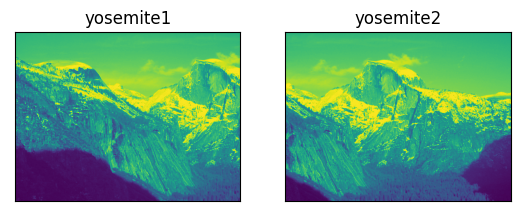

In [78]:
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('yosemite/yosemite1.jpg')
img2 = cv2.imread('yosemite/yosemite2.jpg')


gs1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gs2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.subplot(121), plt.imshow(gs1)
plt.title('yosemite1'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(gs2)
plt.title('yosemite2'), plt.xticks([]), plt.yticks([])
plt.show()

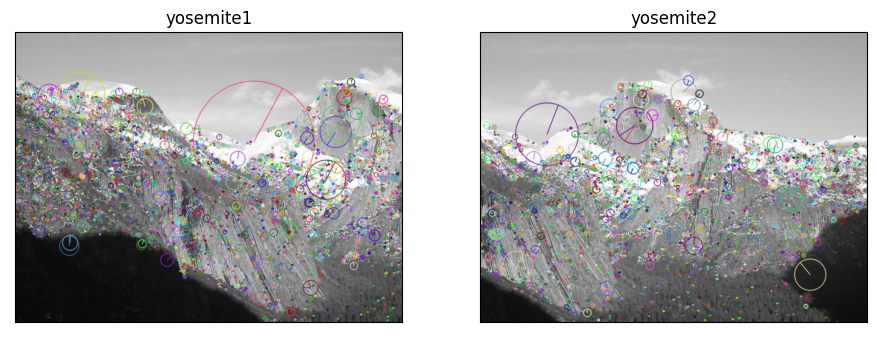

In [84]:
# Initiate SIFT detector
fig, ax = plt.subplots(1, 2, figsize=(11, 6))

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gs1, None)
draw1 = cv2.drawKeypoints(gs1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax[0].imshow(draw1, cmap = 'gray_r')
ax[0].set_title('yosemite1'), ax[0].set_xticks([]), ax[0].set_yticks([])

kp2, des2 = sift.detectAndCompute(gs2, None)
draw2 = cv2.drawKeypoints(gs2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax[1].imshow(draw2, cmap = 'gray_r')
ax[1].set_title('yosemite2'), ax[1].set_xticks([]), ax[1].set_yticks([])

plt.show()

# Feature Matching

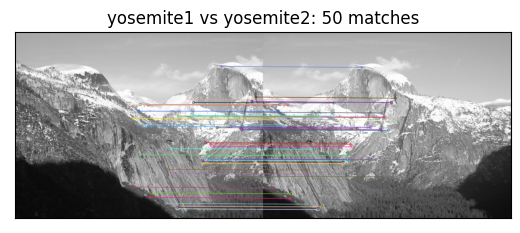

In [121]:
# Initiate matcher
top_n = 50

bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(gs1, kp1, gs2, kp2, matches[:top_n], None, flags=2)
plt.imshow(img3), plt.title(f'yosemite1 vs yosemite2: {top_n} matches'), plt.xticks([]), plt.yticks([])
plt.show()

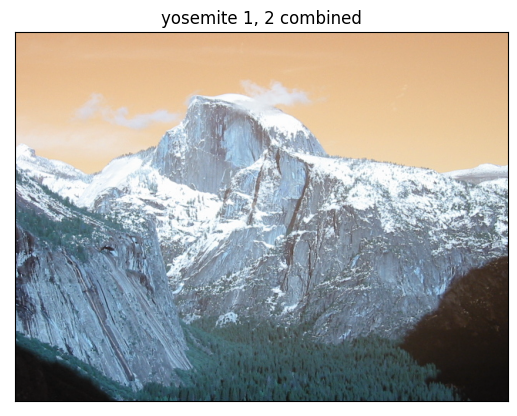

In [137]:
# Construct correspondences
import numpy as np

pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

homography, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
warp = cv2.warpPerspective(img1, homography, (img1.shape[1], img1.shape[0]))
img1_mask = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)
img1_mask = cv2.warpPerspective(img1_mask, homography, (img1.shape[1], img1.shape[0]))
warp[img1_mask == 0] = img2[img1_mask == 0]
plt.imshow(warp), plt.title('yosemite 1, 2 combined'), plt.xticks([]), plt.yticks([])
plt.show()